In [30]:
import os.path
import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cf
import cmocean
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import dask
import easygems
import easygems.healpix as egh
from scipy.interpolate import griddata
import matplotlib.colors as mcolors

In [65]:
data_dir = '~/lehre/msc-intro-computational-meteorology-exercises-w2025/ERA5'
t2m_wind_10m_path = os.path.join(data_dir, 'ERA5_monthly.1940-2025.t2m_wind10_pres.1deg.nc')
#precip_radflx_path = os.path.join(data_dir, 'ERA5_monthly.1940-2025.precip_radflx.1deg.nc')

In [66]:
t2m_wind_10m = xr.open_dataset(t2m_wind_10m_path)
t2m = t2m_wind_10m['t2m']
u10 = t2m_wind_10m['u10']
v10 = t2m_wind_10m['v10']
#del(data_dir, t2m_wind_10m_path)
#t2m_wind_10m

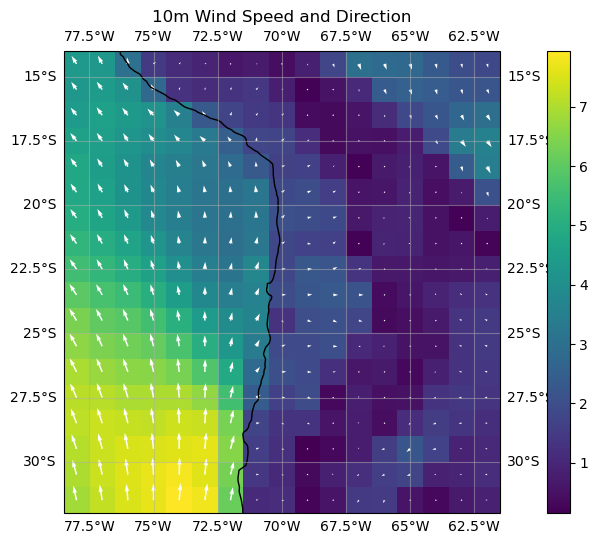

(<Figure size 1200x600 with 2 Axes>,
 <GeoAxes: title={'center': '10m Wind Speed and Direction'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>)

In [ ]:
def mask_and_filter(ds, by_time=False, time=None, by_latlon=False, bounds=[-32, -14, 360-78, 360-62]):
    if by_time and time is None:
        raise ValueError("If filtering by time, a timestep must be supplied (time=?)")
    lat_min, lat_max,lon_min, lon_max = bounds

    ds_out = ds

    if by_time:
        try:
            ds_out = ds.isel(valid_time=time)
        except Exception:
            ds_out = ds.isel(time=time)

    if by_latlon:
        where_clause = (ds_out.lat >= lat_min) & (ds_out.lat <= lat_max) & (ds_out.lon >= lon_min) & (ds_out.lon <= lon_max)
        ds_out = ds_out.where(where_clause, drop=True)
    
    return ds_out

def wind_speed_map(u10_single_timestep, v10_single_timestep, skip=1, show=True):
    wind_speed = (u10_single_timestep**2 + v10_single_timestep**2)**0.5

    fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

    # Plot wind speed as background
    wind_speed.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', add_colorbar=True)

    # Overlay wind vectors
    u_sub = u10_single_timestep[::skip, ::skip]
    v_sub = v10_single_timestep[::skip, ::skip]

    ax.quiver(
        u_sub.lon, u_sub.lat,
        u_sub.values, v_sub.values,
        transform=ccrs.PlateCarree(),
        color='white',
        scale=200
    )

    ax.coastlines()
    ax.gridlines(draw_labels=True, alpha=0.5)
    ax.set_title('10m Wind Speed and Direction')

    if show:    
        plt.show()   
    return fig, ax

def wind_stream_plot(u10_single_timestep, v10_single_timestep, show=True, density=2):
    lons = u10_single_timestep.lon.values
    lats = u10_single_timestep.lat.values
    u_data = u10_single_timestep.values
    v_data = v10_single_timestep.values

    # Flip latitude if descending
    if lats[0] > lats[-1]:
        lats = lats[::-1]
        u_data = np.flip(u_data, axis=0)
        v_data = np.flip(v_data, axis=0)

    # Convert longitudes to -180/180 for display
    lons_display = np.where(lons > 180, lons - 360, lons)
    print("Lons range:", lons_display.min(), lons_display.max())
    print("Lats range:", lats.min(), lats.max())

    # Create figure with cartopy projection
    fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

    # Add coastlines FIRST
    ax.coastlines(resolution='110m')
    ax.add_feature(cf.LAND, facecolor='lightgray', alpha=0.3)

    # Set the extent
    ax.set_extent([lons_display.min(), lons_display.max(), lats.min(), lats.max()], crs=ccrs.PlateCarree())

    # Now add streamplot WITHOUT transform parameter
    magnitude = np.sqrt(u_data**2 + v_data**2)
    streamplot = ax.streamplot(
        lons_display, lats,
        u_data, v_data,
        density=density,
        color=magnitude,  # or 'blue'
        linewidth=1.5,
        arrowsize=1.5,
        cmap='viridis',  # optional
        zorder=3
    )

    fig.colorbar(streamplot, ax=ax)

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.gridlines(draw_labels=True, alpha=0.3)
    ax.set_title('10m Wind Streamlines')
    if show:
        plt.show()
    return fig, ax

u10_single_timestep = mask_and_filter(u10, by_time=True, time=0, by_latlon=True)
v10_single_timestep = mask_and_filter(v10, by_time=True, time=0, by_latlon=True)

wind_speed_map(u10_single_timestep, v10_single_timestep)